In [2480]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import glob
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates, collections

from stompy import utils, memoize, filters
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils, xr_transect
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
from stompy.spatial import field, proj_utils 
from stompy.model import data_comparison
%matplotlib notebook
turbo=scmap.load_gradient('turbo.cpt')

In [2256]:
dem=field.GdalGrid("../../bathy/junction-composite-20190117-no_adcp.tif")

In [2257]:
six.moves.reload_module(xr_transect)
six.moves.reload_module(sun_driver)

<module 'stompy.model.suntans.sun_driver' from '/home/rusty/src/stompy/stompy/model/suntans/sun_driver.py'>

Check ADCP against gauge flows
---

Conclusion: River Surveyor reports flow 0.914 * Mossdale gauge, and
`xr_transect` flows are 0.918 * Mossdale gauge.

Even though xr_transect doesn't count the near-shore regions, they
are narrow, shallow, and slow in this dataset. The python results
are ever so slightly better (one less outlier) than the River Surveyor
data.

In [2319]:
six.moves.reload_module(xr_transect)

# Load all of the averaged ADCP transects
# Extrapolate to bed/surface
# Add River Surveyor flow results
suffix='-avg_with_time.nc'
obs_tran_fns=glob.glob("../../field/adcp/040518_BT/*"+suffix)
obs_tran_fns.sort()
obs_trans=[]

# Load the flows as calculated by River Surveyor
rivr_Q=pd.read_csv('../../field/adcp/river_surveyor_flows-2018.csv')

# This offset is dialed in to get a match between measured flow
# and gauge flow.  Even though ADCP measured flow (as from python)
# does not include the sides, there is very little flow there, and
# without this offset, python values were almost identical to 
# river surveyor, and slightly better.
z_delta=-0.28


for fn in obs_tran_fns:
    print(fn)
    ds=xr.open_dataset(fn)
    # some transects, through the averaging process, have a sample
    # coordinate that is reversed. To reduce the risk of xarray getting
    # too clever, standardize the sample coordinate:
    ds['sample']=('sample',), np.arange(ds.dims['sample'])
    
    for v in ['z_bed','depth_m']:
        if 'positive' not in ds[v].attrs:
            ds[v].attrs['positive']='down'
            assert ds[v].mean()>0,"Maybe a bad assumption here"
    ds['eta']=(-z_delta) + 0*ds.depth_m
    ds.attrs['fn']=fn
    ds.attrs['label']=os.path.basename(fn).replace(suffix,'').replace('BTref','')
    # ASSUME ADCP is PDT. Have not been able to verify this.
    ds['time']=ds.time+np.timedelta64(7,'h')

    if 1:
        # A little cleanup
        # column with no bed elevation gets deleted
        ds=ds.isel(sample=np.isfinite(ds.z_bed.values))
        xr_transect.mask_bed(ds,ds.U,depth_fraction=0.75,z_top=ds.eta)

    # Strong secondary, particulary transect 7, make the surface power fit
    # not great.
    if ( ('040518_8' in fn) or
         ('040518_9' in fn) ):
        surf_method='constant'
    else:
        surf_method='pow(0.167)'
    print("  surface extrapolation: ",surf_method)

    bed_method='pow(0.167)'
    ds=xr_transect.extrapolate_vertical(ds,
                                        [ ('U',dict(xy=0),bed_method,surf_method),
                                          ('U',dict(xy=1),bed_method,surf_method)],
                                        eta=ds.eta.mean(),z_bed='z_bed',
                                        save_original=True)
    # Not sure where the bug is, but shift_vertical before the extrapolate call
    # does not work.
    xr_transect.shift_vertical(ds,z_delta)
    
    # Add River Surveyor Flows
    Qests=[]
    for idx,row in rivr_Q.iterrows():
        if row['filename'].startswith(ds.label):
            Qests.append(row['flow_m3s'])
    assert len(Qests)>0
    ds['Qmean']=(),np.mean(Qests)
    ds['Qstd']=(),np.std(Qests)
    ds['Qmedian']=(),np.median(Qests)
    obs_trans.append(ds)


../../field/adcp/040518_BT/040318_1_BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_2BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_3_BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_4BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_5BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_6BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_7_BTref-avg_with_time.nc
  surface extrapolation:  pow(0.167)
../../field/adcp/040518_BT/040518_8BTref-avg_with_time.nc
  surface extrapolation:  constant
../../field/adcp/040518_BT/040518_9BTref-avg_with_time.nc
  surface extrapolation:  constant


In [1486]:
# Load MSD flows
import common
six.moves.reload_module(common)
msd_flow=common.msd_flow(np.datetime64('2018-03-10'),
                         np.datetime64('2018-04-20'))

In [1487]:
Qs=[]
Qrivs=[]
times=[]

for tran in obs_trans:
    Q=xr_transect.Qleft(tran)
    Qr=tran.Qmean.item()
    t=tran.time.values
    if tran.label==obs_trans[-1].label:
        # but transects 8 and 9 downstream of the junction on either 
        # side.
        Qs[-1]+=Q
        Qrivs[-1]+=Qr
    else:
        Qs.append(Q)
        Qrivs.append(Qr)
        times.append(t)

<IPython.core.display.Javascript object>


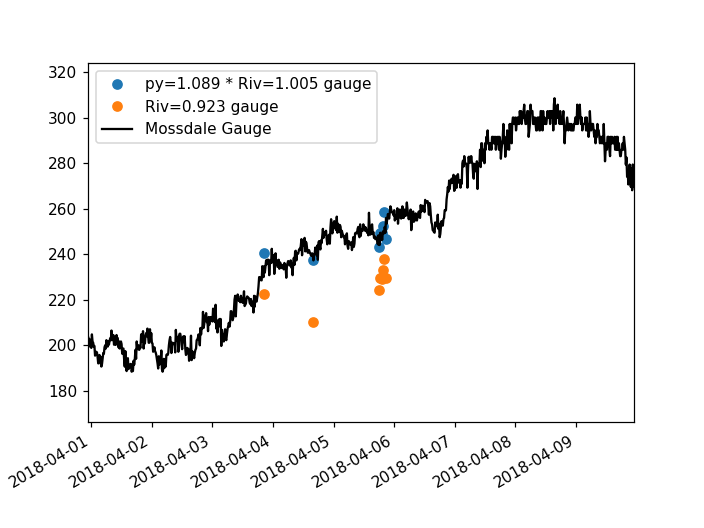

In [1488]:
xr_ratio=np.mean( Qs/Q_at_transect)
riv_ratio=np.mean( Qrivs/Q_at_transect )
xr_to_riv_ratio= np.mean( np.array(Qs)/Qrivs)

fig=plt.figure()
plt.plot(times,Qs,'o',label='py=%.3f * Riv=%.3f gauge'%(xr_to_riv_ratio,xr_ratio))
plt.plot(times,Qrivs,'o',label='Riv=%.3f gauge'%(riv_ratio))

plt.plot(msd_flow.time, # -np.timedelta64(1,'h'),
         msd_flow.flow_m3s,'k-',label='Mossdale Gauge')
plt.legend()
plt.axis((736784.946, 736793.951, 166., 324.))

Q_at_transect = np.interp( times, msd_flow.time, msd_flow.flow_m3s) 
fig.autofmt_xdate()


In [2383]:
ls runs/

cfg006_20180310/          short056.g8.50_20180405/   steady013_20180401/
cfg006_20180401/          short057.g8.50_20180405/   steady014_20180401/
cfg007_20180310/          short058.g8.50_20180405/   steady015_20180401/
cfg007_20180320/          short059.g8.50_20180405/   steady016_20180401/
cfg007_20180330/          short060.g8.50_20180405/   steady017_20180401/
cfg007_20180409/          short061.g8.50_20180405/   steady018_20180401/
short036_20180405/        short062.g8.50_20180405/   steady019_20180401/
short037_20180405/        short063.g8.50_20180405/   steady020_20180401/
short038_20180405/        short064.g8.50_20180402/   steady021_20180401/
short039_20180402/        short065.g8.60_20180405/   steady022_20180401/
short039_20180402-nh/     short066.g8.60_20180405/   steady023_20180401/
short040_20180405/        short067.g8.60_20180405/   steady024_20180401/
short041_20180402/        short068.g8.60_20180402/   steady025_20180401/
short045_20180402/        short069.g8.60_20180405/ 

In [2467]:
six.moves.reload_module(sun_driver)
models=[
#    sun_driver.SuntansModel.load("/opt2/san_joaquin/cfg008/cfg008_20180409"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/cfg007_20180330"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short037_20180405"),
    
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short039_20180402"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short039_20180402-nh"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short047.g8.50_20180402"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short049.g8.50_20180402"),
#    sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short050.g8.50_20180405"),
     
    # DWR, aniso smooth, 4h, z0B=5e-3
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short051.g8.50_20180405"),
    
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short052.g8.50_20180405"),

    # DWR, aniso smooth, 4h, z0B=5e-2
    #sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short053.g8.50_20180405"),
    
    # DWR, aniso smooth, 4h, z0B=5e-3, grid7-45
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short054.g7.45_20180405"),
    
    # DWR, aniso smooth 4h, z0B=5e-3, grid6
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short055.g6_20180405"),

    # DWR, aniso smooth 4h, z0B=5e-3, grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short056.g8.50_20180405"),
  
    # DWR, aniso smooth 4h, z0B=5e-3, grid8, MY2.5, +hor_adv
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short057.g8.50_20180405"),
  
    # DWR, aniso smooth 4h, z0B=5e-3, grid8, parabolic, double vertical res
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short058.g8.50_20180405"),
    
    # DWR, aniso smooth 4h, z0B=5e-4, grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short059.g8.50_20180405"),
    
    # DWR, aniso smooth 4h, z0B=5e-5, grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short060.g8.50_20180405"),
    
    # DWR, aniso smooth 4h, z0B=5e-4, grid8, parabolic, CdW=0.2
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short061.g8.50_20180405"),

    # DWR, aniso smooth, 4h, z0B=Variable (5e-3), grid8, parabolic
    #sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short062.g8.50_20180405"),
    
    # DWR, aniso smooth, 4h, z0B=Variable (1/30), grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short063.g8.50_20180405"),

    # DWR, aniso smooth, 6d, z0B=Variable (1/30), grid8, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short064.g8.50_20180402"),

    # DWR, aniso smooth, 4h, z0B=Variable(1/30), grid8.60 (NEW), parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short065.g8.60_20180405"),
    
    # composite smoothed (just mid chan), 4h, z0B=Variable(1/30), grid8.60, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short066.g8.60_20180405"),
    
    # composite smoothed+adcp, 4h, z0B=Variable(1/30), grid8.60, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short067.g8.60_20180405"),
    
    # composite smoothed+adcp, 6d, z0B=Variable(1/30), grid8.60, parabolic
    # This is the current best.
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short068.g8.60_20180402"),
    
    # composite smoothed+adcp2 (includes ADCP up SJ), 4h, z0B=Variable(1/30), grid8.60, parabolic
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short069.g8.60_20180405"),
    
    # composite smoothed+adcp, 4h, z0B=Variable(1/30), grid8.r03, parabolic
    # double resolution grid
    # sun_driver.SuntansModel.load("/home/rusty/src/hor_flow_and_salmon/model/suntans/runs/short070.g8r.03_20180405"),
    
    # Production version of short068
    sun_driver.SuntansModel.load("/opt2/san_joaquin/cfg010/cfg010_20180330"),
]

for m in models:
    m.projection="EPSG:26910"    
    if len(models)>1:
        m.label=os.path.basename(m.run_dir)
    else:
        m.label='Model'

fig_dir=os.path.join(models[-1].run_dir,'figs-20200526')
os.path.exists(fig_dir) or os.makedirs(fig_dir)

True

In [2409]:
smooth_wx=15
smooth_wz=9

def smooth_adcp(transect,smooth_wx=15,smooth_wz=9):
    transect=transect.copy()
    # Smooth the observations
    U=transect.U.values
    # use an odd winsize!
    if smooth_wx:
        U=filters.lowpass_fir(transect.U.values,winsize=smooth_wx,axis=0)
    if smooth_wz:
        U=filters.lowpass_fir(U,winsize=smooth_wz,axis=1)
    transect['U']=transect['U'].dims,U
    xr_transect.add_rozovski(transect,force_left=True)
    return transect

In [2410]:
@memoize.memoize(lru=20,key_method='str')
def extract_to_match_obs(obs_tran,model,time=None,preserve_angle=False):
    """
    obs_tran: transect to match
    model: SunDriver instance to pull data from
    time: specify time, overriding observation time, for querying model
    preserve_angle: assume obs_tran already has roz_angle, and use the
     same angles to rotate model data.
    """
    chain_interval=(model.chain_stop() - model.chain_start())
    steady=chain_interval<np.timedelta64(1,'D')
    if steady:
        t=-1 # choose the last step
    else:
        t=obs_tran.time.values
        if time is not None:
            t=time
    
    print(f"Extracting transect for time {t}")
    transect=model.extract_transect(xy=np.c_[obs_tran.x_sample,obs_tran.y_sample],
                                    dx=5,time=t)
    
    dzmin_surf=float(model.config.get('dzmin_surface','0.25'))
    
    model.adjust_transect_for_dzmin_surface(transect,update_vars=['U','Ve','Vn'],
                                            dzmin_surf=dzmin_surf)
    bed_offset=np.nanmean( xr_transect.pos_up(transect,'dv')
                          - xr_transect.pos_up(obs_tran,'depth_m'))
    print("Bed offset is ",bed_offset)
    offset=np.nanmean(transect.eta.values)
    xr_transect.shift_vertical(transect,-offset)
    transect.attrs['z_shift']=-offset
    transect['depth_m']=transect['dv']
    transect.attrs['label']=model.label
    if preserve_angle:
        transect['roz_angle']=('sample',),obs_tran['roz_angle'].values
        xr_transect.add_rotated(transect,src='U',dst='Uroz',frame='roz',comp_names=['downstream','left'],
                                angle_field='roz_angle') 
    else:
        xr_transect.add_rozovski(transect)
    return transect

In [2411]:
def print_flows(all_trans):
    # Report flows:
    for tran in all_trans:
        Q=xr_transect.Qleft(tran)
        print(f"{tran.label:20}: Q (xr_transect)={Q:.3f}")
        if 'Qmean' in tran:
            print(f"                      Q (river surveyor)={tran.Qmean.item():.3f}")
        print()

In [2468]:
six.moves.reload_module(xr_transect)
class FigU(object):
    labels=None
    show_flow=False
    z_slice=[-2,0]
    show_bed=False # draw line for bed for each panel
    show_obs_bed=True # show ADCP bed location on model panels
    show_surface=False
    u_cmap=turbo
    delta_cmap='coolwarm'
    outline_valid_obs=True
    outline_valid_model=True
    lateral_quiver=False
    plot_error=False 
    smooth_model=False # apply smooothing to the model output similar to ADCP smoothing
    smooth_average=True # apply smoothing to extracted velocity after extraction.
    u_clim=[0,1.2]
    err_clim=[-0.2,0.2]
    figsize=(9,9)
    def __init__(self,obs_tran,**kw):
        self.obs_tran=obs_tran
        utils.set_keywords(self,kw)
        self.fig=self.fig_uroz()
        
    def plot_uroz(self,tran,ax):
        val=tran.Uroz.sel(roz='downstream')
        if self.plot_error and (tran is not self.all_trans[0]):
            ref=self.all_trans[0].Uroz.sel(roz='downstream')
            val=val-ref
            coll=xr_transect.plot_scalar(tran,val,ax=ax,
                                         cmap=self.delta_cmap,
                                         clim=self.err_clim)
            cset=xr_transect.contour(tran,val,np.linspace(-0.5,0.5,11),
                                     ax=ax,colors='k',linewidths=0.5,)
        else:
            coll=xr_transect.plot_scalar(tran,val,ax=ax,
                                         cmap=self.u_cmap,
                                         clim=self.u_clim)
        if self.show_surface:
            ax.plot(tran.d_sample, tran.eta,'k--',label='surface')
        if self.show_bed:
            ax.plot(tran.d_sample,-tran.depth_m,'k-',label='bed')
        return coll

    def fig_uroz(self):
        obs_tran=smooth_adcp(self.obs_tran)
        mod_trans=[extract_to_match_obs(obs_tran,model,preserve_angle=True)
                   for model in models]
        
        if self.plot_error or self.smooth_model:
            # A bit of a hack -- assumes that the model is positive up
            # and the ADCP positive down.
            new_z=obs_tran.z_ctr.values
            new_mod_trans=[]
            for t in mod_trans: 
                t=xr_transect.resample_z(t,new_z,new_z_positive='down')
                # Smooth the model in the same way as the ADCP
                Uroz=t.Uroz.values
                Uroz=filters.lowpass_fir(Uroz,winsize=smooth_wx,axis=0)
                Uroz=filters.lowpass_fir(Uroz,winsize=smooth_wz,axis=1)
                t['Uroz']=t['Uroz'].dims,Uroz
                new_mod_trans.append(t)
            mod_trans=new_mod_trans
                
        all_trans=[obs_tran]+mod_trans
        self.all_trans=all_trans
        
        # goofy logic to allow appending extra models without worrying about
        # adjusting names passed in.
        labels=self.labels
        if labels is None:
            labels=[]
        for i,t in enumerate(all_trans):
            if i>=len(labels):
                labels.append(t.attrs.get('label',str(i)))

        gs=gridspec.GridSpec(len(all_trans)+1,2,width_ratios=[20,1])
        fig=plt.figure(figsize=self.figsize)
        axs=[]
        for i in range(len(all_trans)):
            if i==0:
                axs.append( fig.add_subplot(gs[i,:-1]))
            else:
                axs.append( fig.add_subplot(gs[i,:-1],
                                            sharex=axs[0],sharey=axs[0]))

        colls=[]

        for tran,ax,label in zip(all_trans,axs,labels):
            coll=self.plot_uroz(tran,ax) # including error plotting
            colls.append(coll)
            ax.text(0.02,0.04,label,transform=ax.transAxes)
            if self.show_obs_bed and (tran is not obs_tran):
                ax.plot(obs_tran.d_sample,-obs_tran.depth_m,'0.5',label='Obs. bed')
            if self.lateral_quiver:
                self.add_quiver(tran,ax)
            if self.show_flow: 
                Q=xr_transect.Qleft(tran)
                ax.text(0.5,0.02,f"Q={Q:.2f} m$^3$/s",transform=ax.transAxes,
                       va='bottom')
            ax.set_ylabel('z (m)')
            plt.setp(ax.get_xticklabels(),visible=0)
        if self.outline_valid_obs: # outline the valid ADCP data
            t=obs_tran
            ax=axs[0]
            xr_transect.contour(t,np.isfinite(t.U_nofill.isel(xy=0)),[0.9],ax=ax,
                                colors='k',linewidths=0.5,linestyles='dashed')
            
        if self.outline_valid_model:
            for t,ax in zip(all_trans[1:],axs[1:]):
                xr_transect.contour(t,np.isfinite(t.U.isel(xy=0)),[0.9],ax=ax,
                                    colors='k',linewidths=0.5,linestyles='dashed')

        axl=fig.add_subplot(gs[-1,:-1],sharex=axs[0])

        for tran,label in zip(all_trans,labels):
            new_z=np.linspace(self.z_slice[0],self.z_slice[1],20)
            tran_slice=xr_transect.resample_z(tran,new_z,new_z_positive='up')
            Uslice=xr_transect.depth_avg(tran_slice,'Uroz')
            u=Uslice.sel(roz='downstream').values
            if self.smooth_average and (tran is not all_trans[0]):
                u=filters.lowpass_fir(u,winsize=smooth_wx,axis=0)
            axl.plot(tran_slice.d_sample,u,label=label)
        axl.legend(loc='upper left',bbox_to_anchor=(1.02,1),frameon=0)
        axl.set_xlabel('Distance (m)')
        axl.set_ylabel('Velocity (m s$^{-1}$)')
        ymin=axl.get_ylim()[0]
        axl.axis(ymin=min(ymin,0))

        if not self.plot_error:
            cax=fig.add_subplot(gs[:-1,-1])
            plt.colorbar(colls[0],cax=cax,label='m s$^{-1}$')
        else:
            nrows=len(self.all_trans)//2
            cax=fig.add_subplot(gs[:nrows,-1])
            plt.colorbar(colls[0],cax=cax,label='m s$^{-1}$')
            cax2=fig.add_subplot(gs[nrows:2*nrows,-1])
            plt.colorbar(colls[1],cax=cax2,label='m s$^{-1}$')
            
        fig.subplots_adjust(wspace=0.07,right=0.85,top=0.97,left=0.11)

        return fig
    def add_quiver(self,tran,ax):
        x_stride=tran.dims['sample']//20
        dz=np.abs(np.nanmedian(tran.z_ctr.diff(dim='layer').values))
        z_stride=int(0.75/dz)
        t_sparse=tran.isel(sample=slice(None,None,x_stride),
                           layer=slice(None,None,z_stride))
        if 'U_nofill' in t_sparse:
            V,X,Z,Vorig = xr.broadcast(t_sparse.Uroz.isel(roz=1),
                                       t_sparse.d_sample,xr_transect.pos_up(t_sparse,'z_ctr'),
                                       t_sparse.U_nofill.isel(xy=0))
            # complicated by the fact that the extrapolation can't deal with
            # secondary flow, so lateral shows up as zero.
            valid=np.isfinite(Vorig.values)
        else:
            V,X,Z = xr.broadcast(t_sparse.Uroz.isel(roz=1),
                                 t_sparse.d_sample,xr_transect.pos_up(t_sparse,'z_ctr'))
            valid=slice(None)
        qset=ax.quiver(X.values[valid],Z.values[valid],
                       -V.values[valid],0*V.values[valid],
                       angles='xy',scale_units='width',scale=2,units='width',
                       width=0.002,pivot='mid',)
        ax.quiverkey(qset,0.9,0.05,0.1,'0.1 m s$^{-1}$',coordinates='axes')

<IPython.core.display.Javascript object>


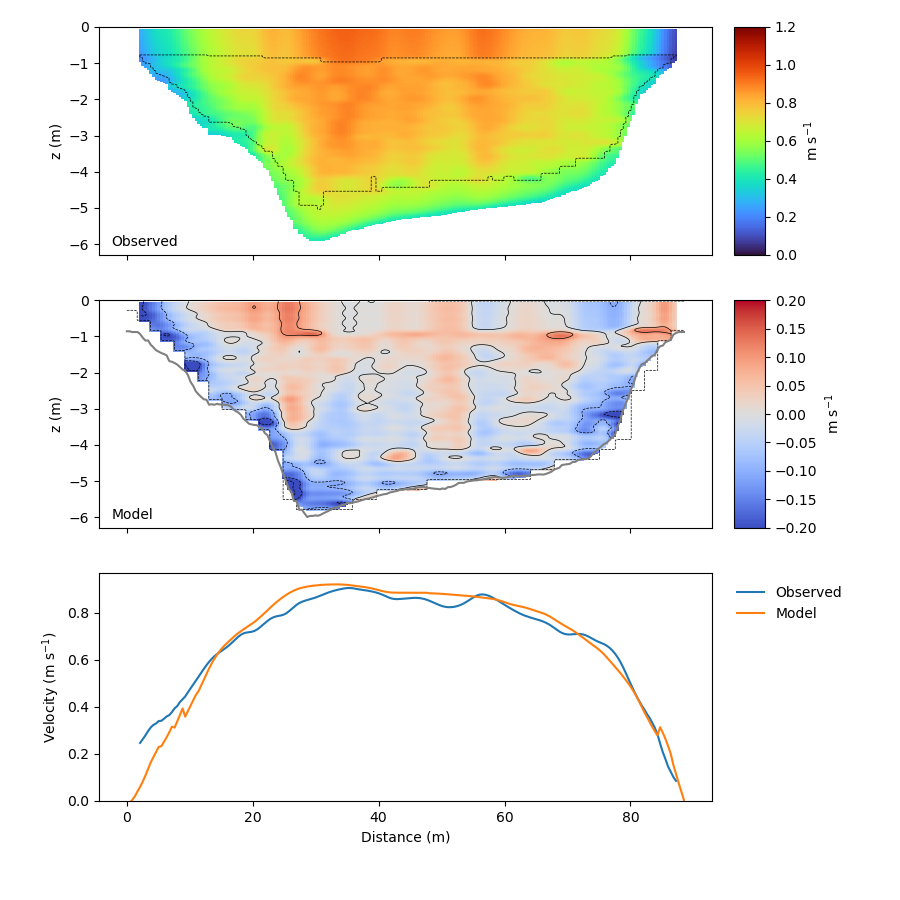

In [2423]:
# For diagnostics:
for t in obs_trans:
    F=FigU(t,labels=['Observed'],z_slice=[-2,0],lateral_quiver=False,plot_error=True)
    break

In [2469]:
fig_dir

'/opt2/san_joaquin/cfg010/cfg010_20180330/figs-20200526'

<IPython.core.display.Javascript object>


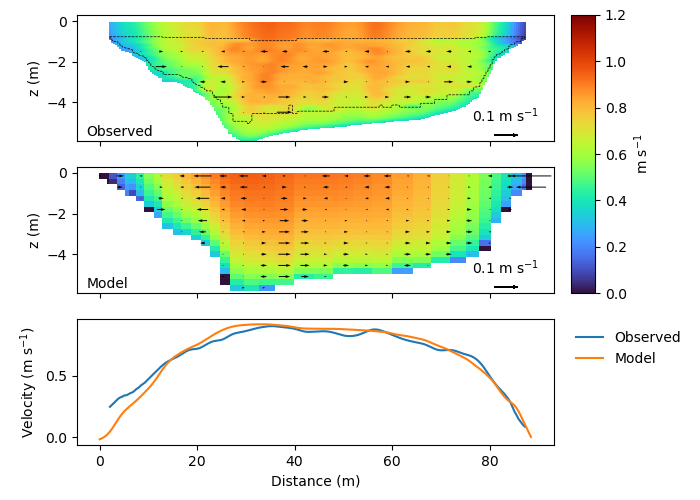

<IPython.core.display.Javascript object>


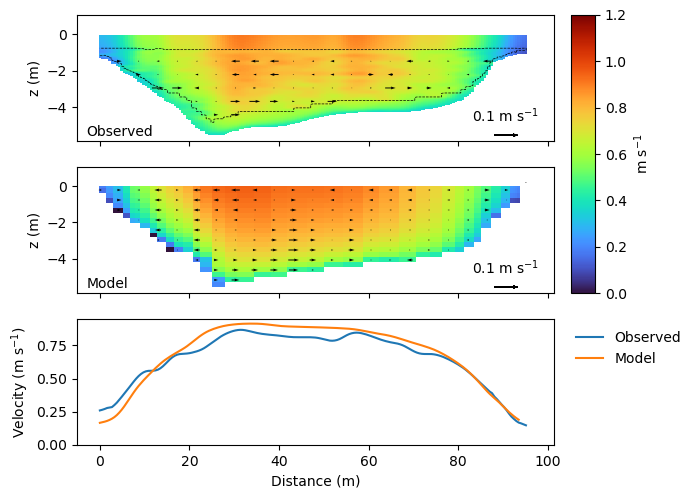

<IPython.core.display.Javascript object>


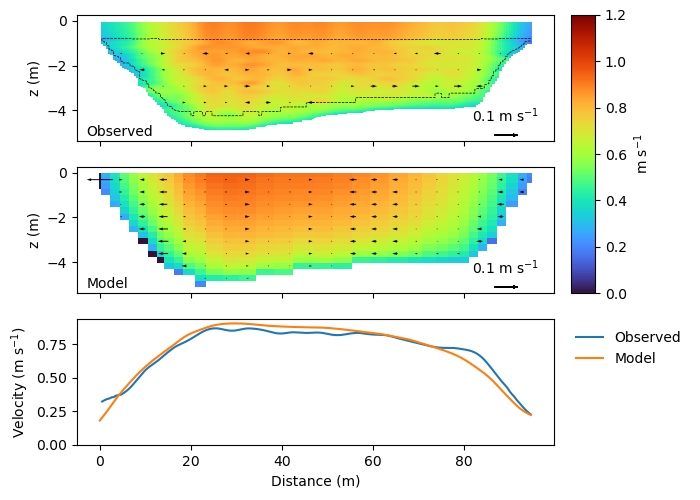

<IPython.core.display.Javascript object>


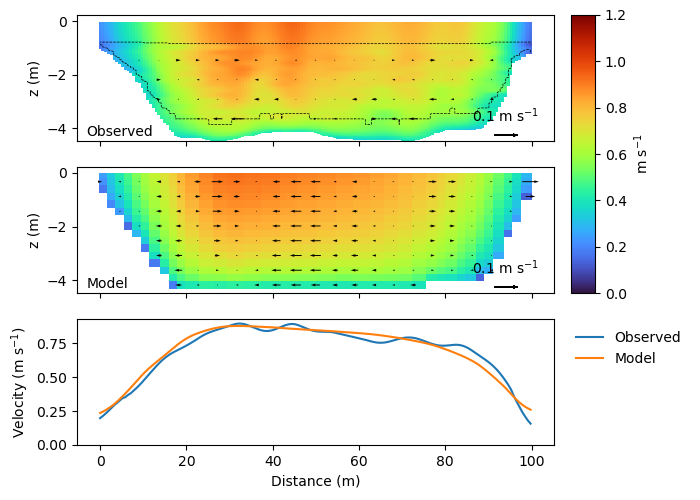

<IPython.core.display.Javascript object>


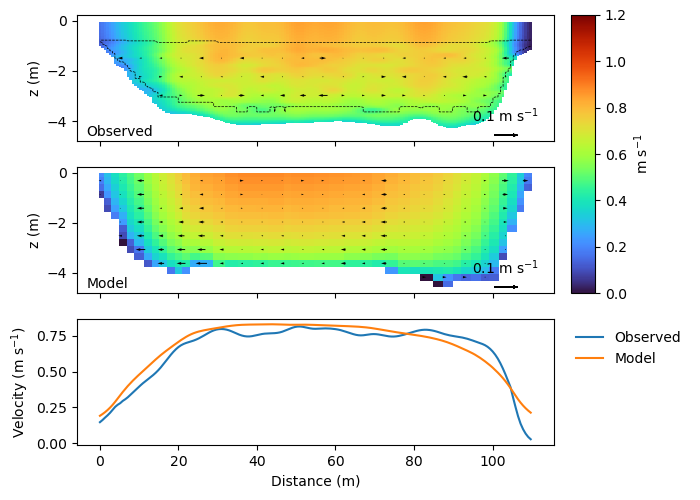

<IPython.core.display.Javascript object>


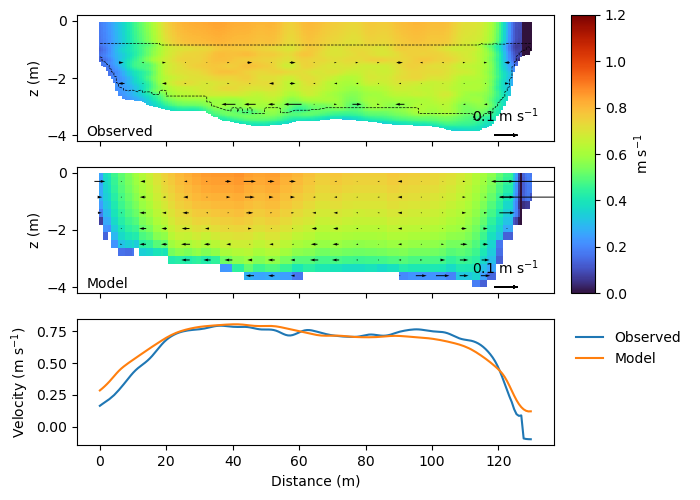

<IPython.core.display.Javascript object>


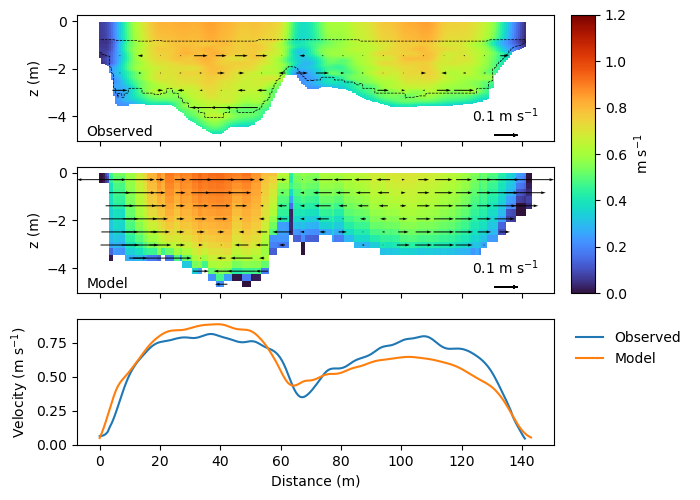

<IPython.core.display.Javascript object>


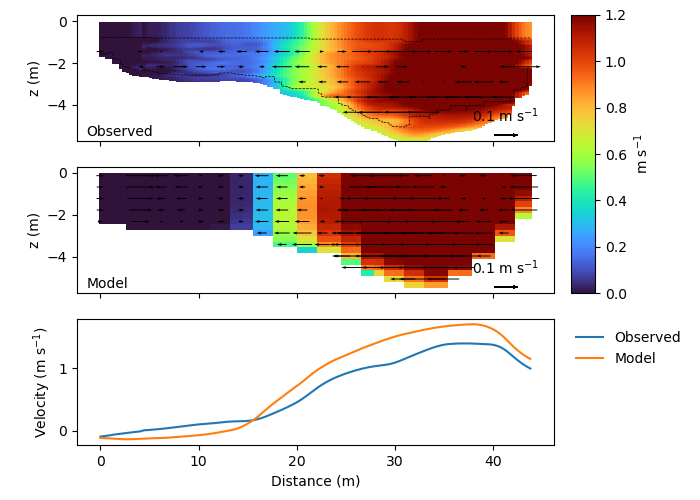

<IPython.core.display.Javascript object>


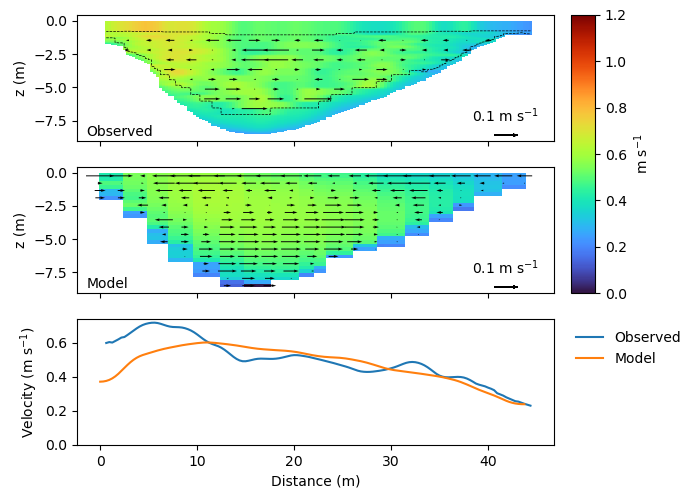

In [2481]:
# For presentation:
for t in obs_trans:
    F=FigU(t,labels=['Observed'],z_slice=[-2,0],lateral_quiver=True,plot_error=False,show_obs_bed=False,
           outline_valid_model=False,smooth_model=False,smooth_average=True,
           figsize=(7,5))
    F.fig.savefig(os.path.join(fig_dir,'tran-%s-slice_with_top2m.png'%t.label),dpi=200)

<IPython.core.display.Javascript object>


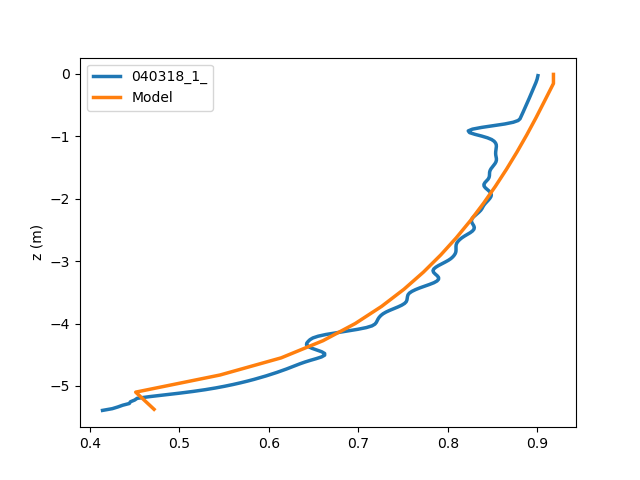

/opt/anaconda3/envs/general/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<IPython.core.display.Javascript object>


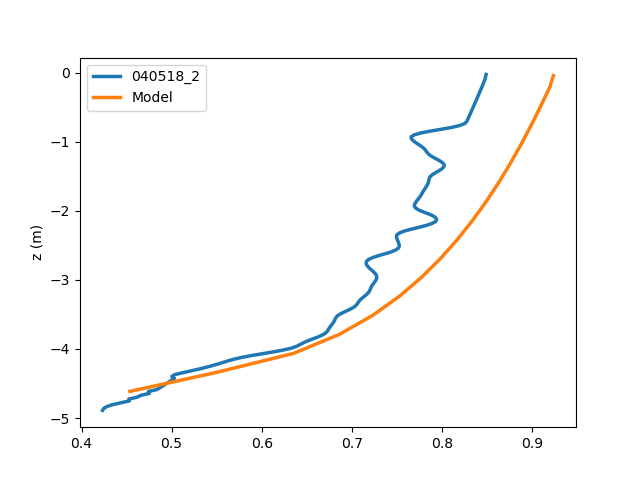

<IPython.core.display.Javascript object>


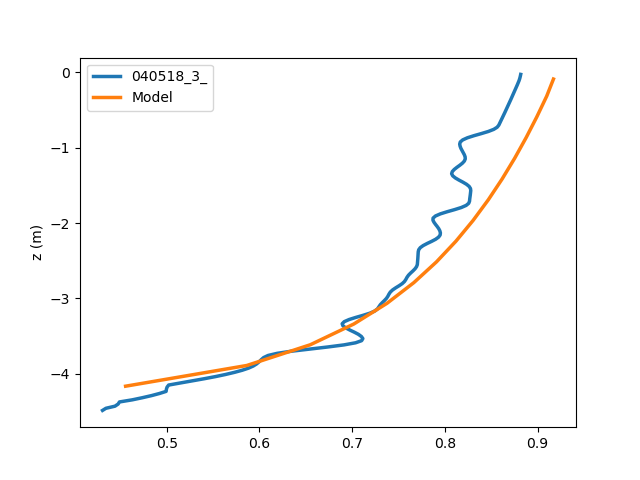

<IPython.core.display.Javascript object>


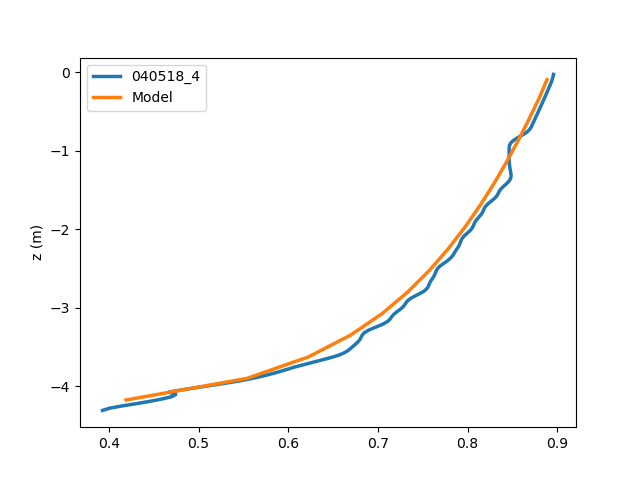

<IPython.core.display.Javascript object>


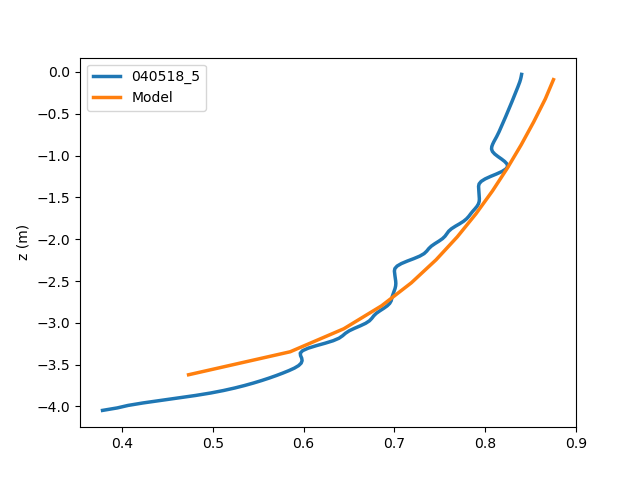

<IPython.core.display.Javascript object>


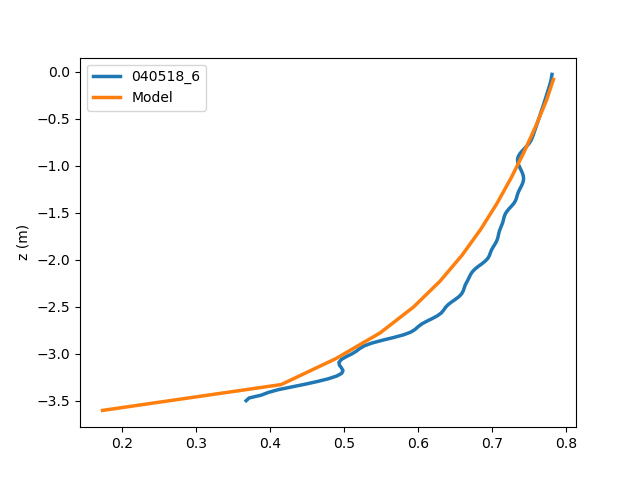

<IPython.core.display.Javascript object>


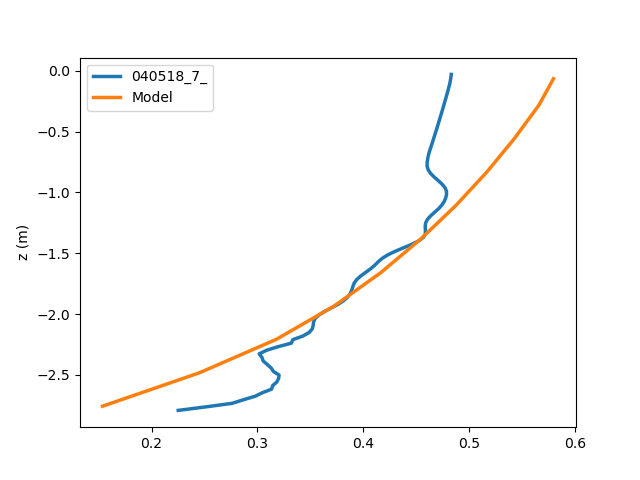

<IPython.core.display.Javascript object>


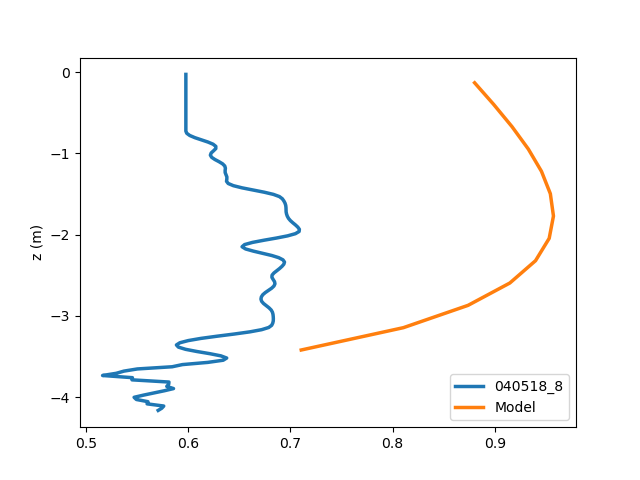

<IPython.core.display.Javascript object>


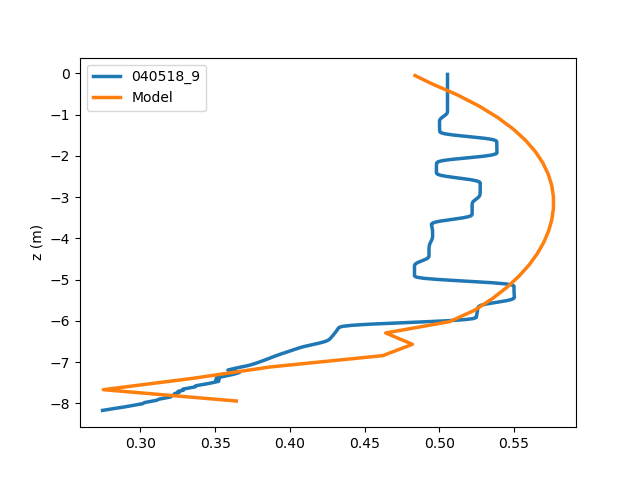

In [2482]:
class FigUProf(FigU):
    """
    Figure comparing vertical profiles of along-channel velocity
    """
    labels=None
    hint_lines=False
    
    def __init__(self,obs_tran,**kw):
        self.obs_tran=obs_tran
        utils.set_keywords(self,kw)
        self.fig=self.fig_uprof()
        
    def plot_uprof(self,tran,ax,sample_sel):
        tranu=tran.sel(roz='downstream',sample=sample_sel)
        
        profile=tranu.isel(sample=0)
        z=xr_transect.pos_up(profile,'z_ctr').values
        
        tran_avg=xr_transect.resample_z(tranu,new_z=z,new_z_positive='up')
        u_avg=tran_avg.Uroz.mean(dim='sample')        
        lines=ax.plot(u_avg,z,lw=2.5)
        color=lines[0].get_color()

        if self.hint_lines:
            for si,s in enumerate(sample_sel):
                profile=tranu.isel(sample=si)
                z=xr_transect.pos_up(profile,'z_ctr')
                ax.plot(profile.Uroz, z, lw=0.3, alpha=0.3, color=color)
        
        return lines[0]

    def fig_uprof(self):
        obs_tran=smooth_adcp(self.obs_tran)
        mod_trans=[extract_to_match_obs(obs_tran,model,preserve_angle=True)
                   for model in models]
        all_trans=[obs_tran]+mod_trans

        n_samp=obs_tran.dims['sample']
        sample_sel=np.arange( int(0.45*n_samp), int(0.55*n_samp) )
        
        fig=plt.figure()
        ax=fig.add_subplot(1,1,1)

        # goofy logic to allow appending extra models without worrying about
        # adjusting names passed in.
        labels=self.labels
        if labels is None:
            labels=[]
        for i,t in enumerate(all_trans):
            if i>=len(labels):
                labels.append(t.attrs.get('label',str(i)))

        lines=[]
        for tran in all_trans:
            line=self.plot_uprof(tran,ax,sample_sel)
            lines.append(line)
        ax.set_ylabel('z (m)')
        ax.legend(lines,labels)
        return fig
for obs_tran in obs_trans:
    FigUProf(obs_tran)

In [2472]:
def prep_for_comparison(obs_tran,models,z_slice,rotate=True,
                        return_datasets=False):
    """
    extract matching transects, smooth observations,
    average over all or part of the water column, return just the
    matched up arrays of velocity.
    rotate: when True, rotate each transect to Rozovski angle from
        observation.
    return_datasets: if True, copy and return the whole dataset,
     with a 'Uavg' field. If False, just return the average data.
    """
    obs_tran=smooth_adcp(obs_tran)
    mod_trans=[extract_to_match_obs(obs_tran,model)
               for model in models]
    trans=[obs_tran] + mod_trans

    # Resample each vertically to just the slice we care about
    if z_slice is not None:
        new_z=np.linspace(z_slice[0],z_slice[1],20)
        trans=[xr_transect.resample_z(tran,new_z,new_z_positive='up')
               for tran in trans]
    # As needed, get on a common lateral coordinate:
    resample_x=False
    for t in trans[1:]:
        if not (np.allclose(trans[0].x_sample.values, 
                            t.x_sample.values)
               and
               np.allclose(trans[0].y_sample.values,
                          t.y_sample.values) ):
            resample_x=True
            break
    if resample_x:
        print("Whoa - why are we resampling?")
        trans=xr_transect.resample_to_common(trans,resample_z=False,save_original=None)
        
    if rotate:
        # Rotate model transects to match ADCP rozovski
        for t in mod_trans:
            t['roz_angle']=('sample',),obs_tran.roz_angle
            xr_transect.add_rotated(t,src='U',dst='Uroz',frame='roz',comp_names=['downstream','left'],
                                    angle_field='roz_angle')    

        # Now use rotated, so biases can be more meaningful
        depth_averages=[ xr_transect.depth_avg(t,'Uroz') for t in trans]
    else:
        depth_averages=[ xr_transect.depth_avg(t,'U') for t in trans]
    if not return_datasets:
        return depth_averages
    else:
        results=[]
        for t,avg in zip(trans,depth_averages):
            t=t.copy()
            t['Uavg']=avg
            results.append(t)
        return results

In [2483]:
ds=xr.Dataset()

tran_names=[t.label for t in obs_trans]

ds['transect_label']=('transect',),tran_names

In [2484]:
# define vertical slices
ds['slice']=('slice',), ['top1m','top2m','full_depth']
ds['slice_nice']=('slice',), ['Top 1m','Top 2m','Full Depth']
ds['slice_defs']=('slice',), [ (-1,0), (-2,0), None]

In [2485]:
ds['models']=('model',), [m.label for m in models]

In [2486]:
ds['obs_avg']=('transect','slice'), np.zeros( (ds.dims['transect'],
                                               ds.dims['slice']), object)
ds['mod_avg']=('transect','slice','model'), np.zeros( (ds.dims['transect'],
                                                       ds.dims['slice'],
                                                       ds.dims['model']), object)

In [2487]:
for obs_i,obs_tran in enumerate(obs_trans):
    print("Transect",obs_i)
    for sl_i,sl in enumerate(ds.slice_defs.values):
        print(f'  Slice {sl}')
        depth_averages = prep_for_comparison(obs_tran,models,z_slice=sl)
        ds['obs_avg'].values[obs_i,sl_i]=depth_averages[0]
        for mod_i,mod_avg in enumerate(depth_averages[1:]):
            ds['mod_avg'].values[obs_i,sl_i,mod_i]=mod_avg

Transect 0
  Slice (-1, 0)
  Slice (-2, 0)
  Slice None
Transect 1
  Slice (-1, 0)
  Slice (-2, 0)
  Slice None
Transect 2
  Slice (-1, 0)
  Slice (-2, 0)
  Slice None
Transect 3
  Slice (-1, 0)
  Slice (-2, 0)
  Slice None
Transect 4
  Slice (-1, 0)
  Slice (-2, 0)
  Slice None
Transect 5
  Slice (-1, 0)
  Slice (-2, 0)
  Slice None
Transect 6
  Slice (-1, 0)
  Slice (-2, 0)
  Slice None
Transect 7
  Slice (-1, 0)
  Slice (-2, 0)
  Slice None
Transect 8
  Slice (-1, 0)
  Slice (-2, 0)
  Slice None


In [2488]:
# Add metrics
ds['obs_std']=('transect','slice'),np.zeros((ds.dims['transect'],ds.dims['slice']),np.float64)
for f in ['rmse','mae','ub_rmse','bias_u','bias_v','mod_std']:
    ds[f]=('transect','slice','model'), np.zeros((ds.dims['transect'],ds.dims['slice'],ds.dims['model']))

In [2489]:
all_obs_u=[]

for t_i,t in enumerate(ds.transect):
    for sl_i,sl in enumerate(ds.slice):
        obs_avg=ds.obs_avg.isel(transect=t_i,slice=sl_i).item()
        all_obs_u.append(obs_avg.values)
        
        ubar=obs_avg.mean(dim='sample')
        obs_std=np.sqrt(np.nanmean( (obs_avg.values-ubar.values)**2))
        ds.obs_std.values[t_i,sl_i]=obs_std
        
        for m_i,model in enumerate(ds.model):
            sel_kw=dict(transect=t_i,slice=sl_i,model=m_i)
            mod_avg=ds.mod_avg.isel(sel_kw).item()
            
            err=mod_avg.values-obs_avg.values
            err_mag=utils.mag(err)

            err_mean=np.nanmean(err,axis=0)
            uberr=mod_avg.values-err_mean-obs_avg.values
            uberr_mag=utils.mag(uberr)
            ds['rmse'].isel(sel_kw).values[...]=np.sqrt(np.nanmean(err_mag**2))
            ds['ub_rmse'].isel(sel_kw).values[...]=np.sqrt(np.nanmean(uberr_mag**2))
            ds['mae'].isel(sel_kw).values[...]=np.nanmean(err_mag)
            ds['bias_u'].isel(sel_kw).values[...]=err_mean[0]
            ds['bias_v'].isel(sel_kw).values[...]=err_mean[1]
            
            # This would be better done as proper Q/A, not average
            # over depth-averages.
            mod_ubar=mod_avg.mean(dim='sample')
            mod_std=np.sqrt(np.nanmean( (mod_avg.values-mod_ubar.values)**2 ))
            ds['mod_std'].isel(sel_kw).values[...]=mod_std            

In [2490]:
# For each slice, calculate standard deviation of velocities across
# all observed transects
slice_stds=[]

for sl_i,sl in enumerate(ds.slice):
    all_obs_u=[ ds.obs_avg.isel(transect=t_i,slice=sl_i).item().values
                for t_i,t in enumerate(ds.transect) ]
    all_obs_u=np.concatenate(all_obs_u,axis=0)
    all_ubar=np.nanmean(all_obs_u,axis=0)

    all_std=np.sqrt(np.nanmean( (all_obs_u - all_ubar)**2))
    slice_stds.append(all_std)
    
ds['global_std']=('slice',),slice_stds

In [2491]:
signs=1-2*(ds['mod_std']<ds['obs_std'])
ds['ubs_rmse']=signs*ds['ub_rmse']

In [2492]:
with open('model-slice-comparisons-20200604.pkl','wb') as fp:
    pickle.dump(ds,fp,protocol=-1)

In [2493]:
ds_metrics=ds.copy()
del ds_metrics['obs_avg']
del ds_metrics['mod_avg']

In [2494]:
df=ds_metrics.isel(slice=0).to_dataframe()
df

transect_label  slice slice_nice slice_defs models  obs_std  \
model transect                                                               
0     0             040318_1_  top1m     Top 1m    (-1, 0)  Model   0.1446   
      1              040518_2  top1m     Top 1m    (-1, 0)  Model   0.1409   
      2             040518_3_  top1m     Top 1m    (-1, 0)  Model   0.1231   
      3              040518_4  top1m     Top 1m    (-1, 0)  Model   0.1388   
      4              040518_5  top1m     Top 1m    (-1, 0)  Model   0.1441   
      5              040518_6  top1m     Top 1m    (-1, 0)  Model   0.1507   
      6             040518_7_  top1m     Top 1m    (-1, 0)  Model   0.1419   
      7              040518_8  top1m     Top 1m    (-1, 0)  Model   0.3735   
      8              040518_9  top1m     Top 1m    (-1, 0)  Model   0.1003   

                  rmse     mae  ub_rmse  bias_u  bias_v  mod_std  global_std  \
model transect                                                                 
0     0         0.0676  0.0534   0.0659  0.0141  0.0051   0.1937      0.1758   
      1         0.0711  0.0620   0.0568  0.0424  0.0044   0.1621      0.1758   
      2         0.0546  0.0493   0.0531  0.0123  0.0038   0.1488      0.1758   
      3         0.0489  0.0442   0.0461  0.0161  0.0009   0.1378      0.1758   
      4         0.0743  0.0665   0.0644  0.0370  0.0013   0.1322      0.1758   
      5         0.1015  0.0676   0.0975  0.0279 -0.0022   0.1276      0.1758   
      6         0.1296  0.1195   0.1262  0.0038 -0.0294   0.1578      0.1758   
      7         0.3172  0.2885   0.2606  0.1529  0.0967   0.5265      0.1758   
      8         0.1253  0.1039   0.1061 -0.0369  0.0555   0.0793      0.1758   

                ubs_rmse  
model transect            
0     0           0.0659  
      1           0.0568  
      2           0.0531  
      3          -0.0461  
      4          -0.0644  
      5          -0.0975  
      6           0.1262  
      7           0.2606  
      8          -0.1061

<IPython.core.display.Javascript object>


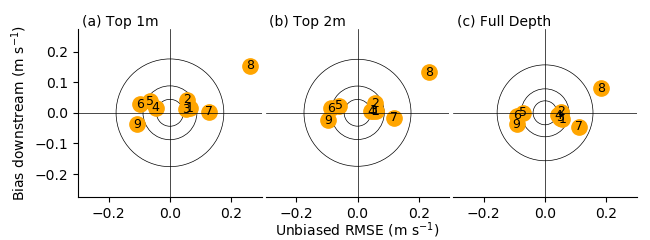

In [2495]:
# Try some target-diagram-ish plots:
from matplotlib.patches import Circle

xmax=0.3

for m_i in range(ds_metrics.dims['model']):
    fig,axs=plt.subplots(1,ds_metrics.dims['slice'],figsize=(6.5,2.4))

    for sl,ax in enumerate(axs):
        sub_ds=ds_metrics.isel(slice=sl,model=m_i)
        df=sub_ds.to_dataframe()

        t_x=df.ubs_rmse
        t_y=df.bias_u
        ax.plot(t_x,t_y,'o',color='orange',ms=11)

        for t_i,(x,y) in enumerate(zip(t_x,t_y)):
            if x>xmax:
                ax.text(xmax,y,r"%d$\rightarrow$"%(t_i+1),ha='right',va='center')
            elif x<-xmax:
                ax.text(-xmax,y,r"$\leftarrow$%d"%(t_i+1),ha='left',va='center')
            else:
                ax.text(x,y,"%d"%(t_i+1),ha='center',va='center',fontsize=9)

        ax.axhline(0,color='k',lw=0.5)
        ax.axvline(0,color='k',lw=0.5)
        ax.set_ylabel('Bias downstream (m s$^{-1}$)')
        ax.axis('equal')

        for r in np.array([0.25,0.5,1.0]) * sub_ds.global_std.item():
            circ=Circle([0,0],r,ec='k',fc='none',lw=0.5)
            ax.add_patch(circ)
        ax.axis(xmin=-xmax,xmax=xmax,ymin=-xmax,ymax=xmax)

        # Make an axes label like '(a) Top 1m'
        ax_lbl=f"({'abcdef'[sl]}) {sub_ds['slice_nice'].item()}"
        ax.text(0.02,1.0,ax_lbl,transform=ax.transAxes,va='bottom')

    for ax in axs[1:]:
        plt.setp(ax.get_yticklabels(),visible=0)
        plt.setp(ax.yaxis.label,visible=0)
        plt.setp(ax.xaxis.label,visible=0)

    fig.subplots_adjust(top=0.88,left=0.12,right=0.98,bottom=0.18,wspace=0.02)
    # Share the x-axis label
    xlab='Unbiased RMSE (m s$^{-1}$)'

    xmid=0.5*( axs[0].get_position().xmin + axs[-1].get_position().xmax)
    fig.text(xmid,0.02,xlab,ha='center')

    for ax in axs:
        ax.spines['top'].set_visible(0)
        ax.spines['right'].set_visible(0)
    for ax in axs[1:]:
        ax.spines['left'].set_visible(0)
        ax.yaxis.set_visible(0)
    
    if 1:
        fig.savefig('target-diagram-20200516.png',dpi=200)


In [2496]:
# Same thing, but as a table:
for m_i in range(ds_metrics.dims['model']):
    sub_ds=ds_metrics.isel(model=m_i)
    sub_ds['slice']=sub_ds.slice_nice
    sub_ds=sub_ds.rename({'ub_rmse':'URMSD',
                          'bias_u':'BIAS (u)',
                          'transect':'Transect',
                          'slice':'Slice'})
    df=sub_ds.to_dataframe()
    df=df.loc[:,['URMSD','BIAS (u)']]
    df=df.unstack('Slice')
    df=df.set_index(df.index+1)

    pd.set_option('precision',4)
    display(df)
    
None

URMSD                   BIAS (u)                
Slice    Full Depth  Top 1m  Top 2m Full Depth  Top 1m  Top 2m
Transect                                                      
1            0.0565  0.0659  0.0602    -0.0213  0.0141  0.0051
2            0.0521  0.0568  0.0587     0.0028  0.0424  0.0306
3            0.0480  0.0531  0.0497    -0.0154  0.0123  0.0062
4            0.0422  0.0461  0.0445    -0.0086  0.0161  0.0044
5            0.0706  0.0644  0.0599     0.0006  0.0370  0.0232
6            0.0907  0.0975  0.0869    -0.0092  0.0279  0.0143
7            0.1116  0.1262  0.1197    -0.0456  0.0038 -0.0156
8            0.1817  0.2606  0.2346     0.0804  0.1529  0.1328
9            0.0928  0.1061  0.0969    -0.0369 -0.0369 -0.0240

In [2497]:
all_avgs=[prep_for_comparison(obs_tran,models,z_slice=[-2,0],rotate=False,return_datasets=True)
          for obs_tran in obs_trans]

In [2498]:
demc=dem.crop([647000,647550,4.185550e6,4.186070e6])

In [2499]:
from matplotlib import cm
import stompy.plot.cmap as scmap

In [2500]:
light_gray=scmap.cmap_clip(cm.gray_r,0.05,0.4)

<IPython.core.display.Javascript object>


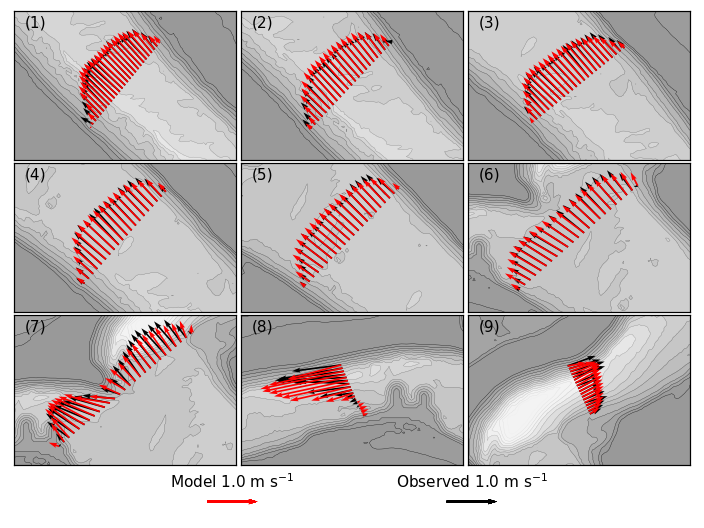

In [2501]:
# Quiver plots
fig,axs=plt.subplots(3,3)

axs=axs.ravel()

colors=['k','r'] # ,'orange','g']
sample_stride=8

for obs_i,(ax,avgs) in enumerate(zip(axs,all_avgs)):
    Qs=[]
    for t,color in zip(avgs,colors):
        t=t.isel(sample=slice(None,None,sample_stride))
        Q=ax.quiver( t.x_sample,t.y_sample, t.Uavg.values[:,0], t.Uavg.values[:,1],
                     color=color, scale_units='xy', scale=0.025,units='xy',angles='xy')
        Qs.append(Q)
    dV=1.0
    demc.contourf(np.arange(-6,6,dV),
                  ax=ax,
                  cmap=light_gray,
                  extend='both',
                  zorder=-2)
    demc.contour(np.arange(-10,6,dV),ax=ax,
                 cmap='gray_r',linewidths=0.2,
                 zorder=-1)
    ax.axis('equal')
    # Can I make them all the same scale?
    cx=t.x_sample.mean()
    cy=t.y_sample.mean()
    dx=60
    ax.axis([cx-dx,cx+dx,cy-dx,cy+dx])
    if obs_i==0:
        # Bottom of the figure
        ax.quiverkey(Qs[1],0.33,0.05,1.0,'Model 1.0 m s$^{-1}$',coordinates='figure')
        ax.quiverkey(Qs[0],0.67,0.05,1.0,'Observed 1.0 m s$^{-1}$',coordinates='figure')
    ax.text(0.05,0.97,f"({1+obs_i})",transform=ax.transAxes,va='top')
            
for ax in axs:
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)

fig.subplots_adjust(top=0.98,bottom=0.12,left=0.02,right=0.98,
                   hspace=0.02,wspace=0.02)

fig.savefig('quiver-compare-top2m-20200516.png',dpi=200)

Velocity overview figure
---

In [2503]:
from stompy.model.fish_ptm import ptm_tools

1379 of 45303 segments unique


/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


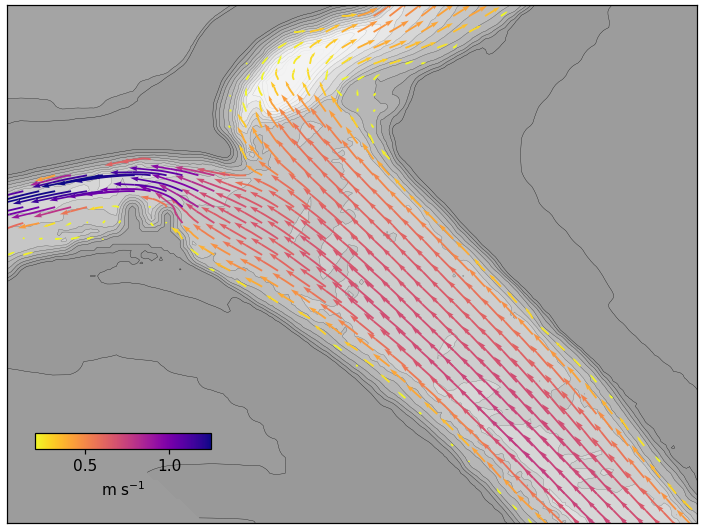

/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


In [2506]:
zoom=(647100., 647456., 4185649., 4185974.)
#cmap=turbo
cmap=cm.plasma_r

pb=ptm_tools.PtmBin('../ptm/streamline_fig/global_bin.out')

_,b0=pb.read_timestep(0)
N=b0['id'].max()

#Nt=pb.count_timesteps()
Nt=20
trajs=np.zeros( (Nt,N,3),np.float64 )
times=[]
for t in range(Nt):
    tstamp,locs=pb.read_timestep(t)
    trajs[t,locs['id']-1,:] = locs['x']
    times.append(utils.to_dt64(tstamp))
    
dry=np.all( trajs[0]==trajs[-1],axis=1)

wet_trajs=trajs[:,~dry,:2]
wet_trajs[ wet_trajs==0]=np.nan
segs=wet_trajs.transpose(1,0,2) # particle,time,{x,y}
# Select segments with unique starting x,y points
starts={}
for i in range(len(segs)):
    seg=segs[i,:,:2]
    k=(seg[0,0],seg[0,1])
    if k in starts: continue
    starts[k]=i
print("%d of %d segments unique"%(len(starts),len(segs)))
sel=np.array(list(starts.values()))
segs=segs[sel]

fig,ax=plt.subplots(1,1)

dt_s=1.0
dx=utils.mag(np.diff(segs,axis=1))
s=np.nanmean(dx/dt_s,axis=1)

valid=np.isfinite(s)
segs=segs[valid]
s=s[valid]
clim=[0.2,1.25]
lcoll=collections.LineCollection(segs,
                                 array=s, clim=clim,cmap=cmap,
                                 lw=1.2)
ax.add_collection(lcoll)

if 1:
    dV=1.0
    demc.contourf(np.arange(-6,6,dV),
                  ax=ax,
                  cmap=light_gray,
                  extend='both',
                  zorder=-2)
    demc.contour(np.arange(-10,6,dV),ax=ax,
                 cmap='gray_r',linewidths=0.2,
                 zorder=-1)
    
ax.axis('equal')
ax.axis(zoom)
ax.yaxis.set_visible(0)
ax.xaxis.set_visible(0)

ax.set_position([0.01,0.01,0.98,0.98])
cax=fig.add_axes([0.05,0.15,0.25,0.03])
plt.colorbar(lcoll,cax=cax,label='m s$^{-1}$',orientation='horizontal')
ax.patch.set_facecolor('#9c9c9c')

# And quiver to put a head on it.
# Need end points, end velocity for each segments
xyuvs=[]
for seg in segs:
    seg=seg[np.isfinite(seg[:,0])]
    xyuvs.append( [seg[-1,0],seg[-1,1],
                   seg[-1,0]-seg[-2,0], seg[-1,1]-seg[-2,1]] )
xyuvs=np.array(xyuvs)
ax.quiver(xyuvs[:,0],xyuvs[:,1],xyuvs[:,2],xyuvs[:,3],s,cmap=cmap,
          clim=clim)
        
fig.savefig('velo-2d-map.png',dpi=200)